In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import matplotlib.patheffects as path_effects
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import clear_output, display
import sys
sys.path.append('../scripts') 
from functions import *
from config import nutrient_info, conversion_factors, origin_map
%load_ext autoreload
%autoreload 2

In [2]:
df_food = pd.read_csv('../data/df_food_filtered_with_food_group.csv')
df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')

C:\Users\Sophie\AppData\Local\Temp\ipykernel_356\1308445948.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv('../data/df_food_filtered_with_food_group.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_356\1308445948.py:2: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_356\1308445948.py:3: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')


In [3]:
qualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'qualifying'}
disqualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'disqualifying'}

qualifying_list   = list(qualifying_nutrients.keys())
disqualifying_list = list(disqualifying_nutrients.keys())

In [4]:
qualifying_cols = [f"{nutr}_ratio_scaled" for nutr in qualifying_nutrients.keys()]
disqualifying_cols = [f"{nutr}_ratio_scaled" for nutr in disqualifying_nutrients.keys()]

In [39]:
mean_qi_per_nutrient = df_food_clean_scaled[qualifying_cols].mean()
most_limiting_qi_nutrient = mean_qi_per_nutrient.sort_values().head(13)
print('Worst performing nutrient for QI :')
print(most_limiting_qi_nutrient)

Worst performing nutrient for QI :
all_trans_retinol_equivalents_activity_eaten_ratio_scaled    0.307672
vitamin_d_eaten_ratio_scaled                                 0.330202
vitamin_e_activity_eaten_ratio_scaled                        0.439299
iron_eaten_ratio_scaled                                      0.487814
water_eaten_ratio_scaled                                     0.496332
potassium_eaten_ratio_scaled                                 0.579571
folate_eaten_ratio_scaled                                    0.607605
calcium_eaten_ratio_scaled                                   0.610658
magnesium_eaten_ratio_scaled                                 0.712460
vitamin_b1_eaten_ratio_scaled                                0.758088
niacin_eaten_ratio_scaled                                    0.804354
zinc_eaten_ratio_scaled                                      0.878268
pantothenic_acid_eaten_ratio_scaled                          0.885941
dtype: float64


In [6]:
mean_di_per_nutrient = df_food_clean_scaled[disqualifying_cols].mean()
most_driving_di_nutrient = mean_di_per_nutrient.sort_values(ascending=False).head(5)
print('Top 5 most excessive problematic nutrient for DI :')
print(most_driving_di_nutrient)

Top 5 most excessive problematic nutrient for DI :
sodium_eaten_ratio_scaled                   1.149650
fatty_acids_saturated_eaten_ratio_scaled    0.993372
sugar_eaten_ratio_scaled                    0.812256
salt_eaten_ratio_scaled                     0.795514
fat_eaten_ratio_scaled                      0.784429
dtype: float64


In [31]:
impacts_qi = {}
original_QI = df_food_clean_scaled[qualifying_cols].mean(axis=1)

for nutr in qualifying_cols:
    tmp = df_food_clean_scaled.copy()
    tmp[nutr] = 1.0
    new_QI = tmp[qualifying_cols].mean(axis=1)
    impacts_qi[nutr] = (new_QI - original_QI).mean() * 100

impact_series = pd.Series(impacts_qi).sort_values(ascending=False)
print("Average QI boost by fixing each nutrient to 1.0 (%):")
print(impact_series.head)

Average QI boost by fixing each nutrient to 1.0 (%):
<bound method NDFrame.head of all_trans_retinol_equivalents_activity_eaten_ratio_scaled    3.461641
vitamin_d_eaten_ratio_scaled                                 3.348990
vitamin_e_activity_eaten_ratio_scaled                        2.803506
iron_eaten_ratio_scaled                                      2.560929
water_eaten_ratio_scaled                                     2.518340
potassium_eaten_ratio_scaled                                 2.102143
folate_eaten_ratio_scaled                                    1.961973
calcium_eaten_ratio_scaled                                   1.946712
magnesium_eaten_ratio_scaled                                 1.437700
vitamin_b1_eaten_ratio_scaled                                1.209561
niacin_eaten_ratio_scaled                                    0.978229
zinc_eaten_ratio_scaled                                      0.608661
pantothenic_acid_eaten_ratio_scaled                          0.570294
vitamin

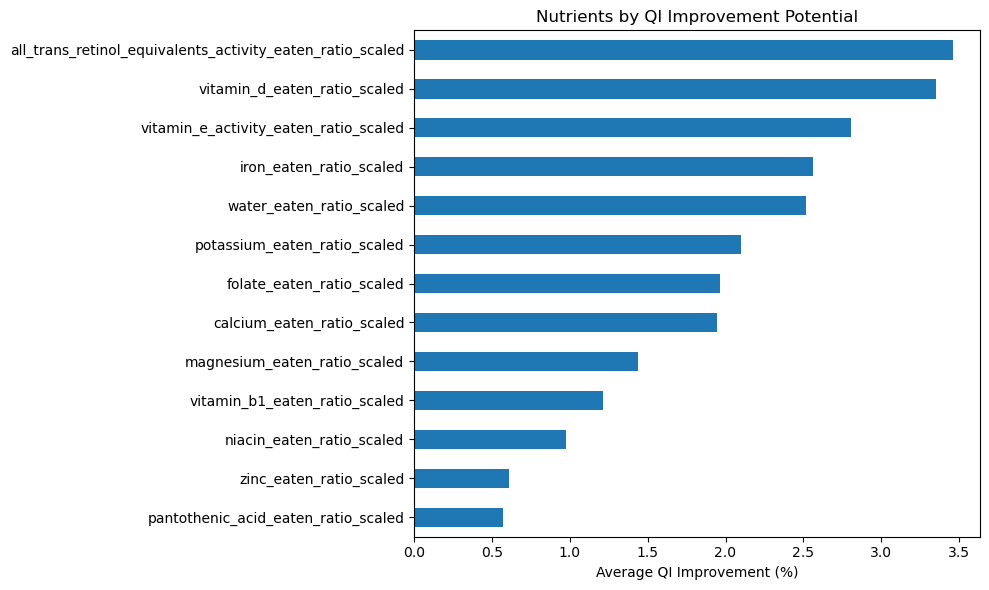

In [41]:
top10 = impact_series.sort_values(ascending=False).head(13)

save_path = 'graphs'

# Plot a horizontal bar chart for readability
plt.figure(figsize=(10, 6))
top10.sort_values().plot(kind='barh')
plt.xlabel('Average QI Improvement (%)')
plt.title('Nutrients by QI Improvement Potential')
plt.tight_layout()
filename = f"{save_path}/nutrients_by_QI_improvement_potential.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

This bar chart is showing, for each of your top-10 most “limiting” nutrients, how much the **average QI** across all foods would **increase**, in percentage points, if you could magically raise that one nutrient’s **qiⱼ** up to exactly **1.0** (i.e. 100% of its DRI per 2 000 kcal).

  By definition,

  $$
    qi_j = \frac{\text{(nutrient amount per 2 000 kcal)}}{\text{DRI}_j}.
  $$

  So setting $qi_j = 1$ is equivalent to saying “this food now provides exactly 100% of the DRI for nutrient $j$ per 2 000 kcal.”

* **How the impact is computed**

  1. Computation of the *original* QI, i.e. the mean of all its qiⱼ values
  2. For a given nutrient $j$, increase of the food’s qi to is 1.0 (regardless of its real, lower value)
  3. Re-computation of each food’s QI under the change
  4. Calculate the percentage between the new QI compared to the original 

* **Sensitivity of QI**

  *“All else equal, if I could fix one nutrient so that its qi hits the DRI threshold, how much would my overall diet quality index jump?”*

  That’s why we cap at **1.0**—because anything above 100% of the DRI doesn’t further improve QI, and below 100% is exactly where the deficit drags the average down.

